## CS 893 Advanced Computer Vision (Assignment No 03)

This assignment is about semantic segmentation. The dataset is a subset of cityscapes dataset which contains street scenery. The dataset is anotated into 12 classes (11 objects and 01 background). <br>
Two architectures have been implemented for this problem. <br>
1.U-Net with a backbone of VGG16 pretrained on imagenet dataset <br>
2.A variation of U-Net with ASPP block in the bottleneck layer with a backbone of Densenet121 pretrained on imagenet dataset

## Required Modules to be installed

In [33]:
# ! pip install albumentations
# ! pip install tqdm

## Import Requisite Modules

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
from skimage.transform import resize
from glob import glob
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Input, Conv2DTranspose 
from tensorflow.keras.layers import Concatenate, BatchNormalization, ReLU, Softmax, AveragePooling2D, UpSampling2D  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras import backend as K
from tqdm import tqdm
import albumentations as A
import os
import shutil
%matplotlib inline

## Unpacking Dataset on Google Colab

In [34]:
# import shutil
# from google.colab import drive
# drive.mount('/content/drive')
# sourceFilePath = os.path.join('drive','My Drive', 'Colab Notebooks', 'Assignment 3','A3_Dataset.zip')
# shutil.unpack_archive(sourceFilePath)
# ! nvidia-smi

## Dataset Preprocessing <br>
Custom Datagenerator class is used for passing the images and masks in batches to the model for training. <br>
Custom Datagenerator is also capable of augmenting the dataset on the fly. <br>
For augmentation 'albumentations' library has been used. <br>

In [2]:
# This function is used for randomly splitting the dataset into training and validation datasets
def DatasetSplit(imageNameList, maskNameList, valPercentage):
    trainImageNameList = imageNameList.copy()
    trainMaskNameList = maskNameList.copy()
    noOfValImages = int(len(trainImageNameList)*valPercentage/100)
    valImageNameList = sorted(random.sample(trainImageNameList, noOfValImages))
    valMaskNameList = []
    for i in valImageNameList:
        trainImageNameList.remove(i)
        fileName = os.path.split(i)[1]
        valMaskNameList.append(os.path.join(trainMaskDir,fileName))
        trainMaskNameList.remove(os.path.join(trainMaskDir,fileName))
    return trainImageNameList, trainMaskNameList, valImageNameList, valMaskNameList

# This class is used for custom data generator
# It reads the images and corresponding masks from hard disk and apply desired transformations and return batches to the training model
class CustomDataGenerator:
    "Custom DataGenerator Class"
    def __init__(self, imageList, maskList, batchSize, augmentationFlag = False):
        self.imageList = imageList
        self.maskList = maskList
        self.batchSize = batchSize
        self.augmentationFlag = augmentationFlag
    # Read images and masks acording the file path lists    
    def ProcessPath(self, imageList, maskList):
        image = tf.io.read_file(imageList)
        image = tf.image.decode_png(image, channels=3)
        mask = tf.io.read_file(maskList)
        mask = tf.image.decode_png(mask, channels=1)
        return image, mask
    # Apply desired augmentation using albumentations library
    def ApplyAugmentation(self, image, mask):
        augTransform = A.Compose([A.HorizontalFlip(p=0.5),A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0, rotate_limit=5, p=0.5), 
                           A.RandomCrop(IMAGESIZE, IMAGESIZE), A.RandomBrightnessContrast(p=0.5)])
        data = {"image": image, "mask": mask}
        aug_data = augTransform(**data)
        image = aug_data["image"]
        mask = aug_data["mask"]
        return image, mask

    def ProcessAugmentation(self, image, mask):
        image, mask = tf.numpy_function(func=self.ApplyAugmentation, inp=[image, mask], Tout=[tf.uint8, tf.uint8]) 
        return image, mask
    # Convert mask into one hot vector and adjust image/mask shape according to required model input
    def PostProcessAugmentation(self, image, mask):
        mask.set_shape([None, None, 1])
        mask = tf.image.resize(images=mask, size=[IMAGESIZE, IMAGESIZE])
        mask = K.cast(mask, dtype='int32')
        mask = K.squeeze(mask, axis=2)
        mask = K.one_hot(mask,NUMCLASSES)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGESIZE, IMAGESIZE])
        # img = img / 127.5 - 1
        image = image / 255.0
        return image, mask
    # Generate data generator using tensorflow dataset module
    def DataGenerator(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.imageList, self.maskList))
        dataset = dataset.map(self.ProcessPath, num_parallel_calls=tf.data.AUTOTUNE)
        if self.augmentationFlag:
            dataset = dataset.map(self.ProcessAugmentation, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
        dataset = dataset.map(self.PostProcessAugmentation, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batchSize)
        return dataset

## Support functions for Dataset analysis

In [3]:
# This function is used for reading training masks
def ReadGroundTruthMasks(trainMaskNameList):
    groundTruthMaskList = []
    for i in trainMaskNameList:
        mask = io.imread(i)
        groundTruthMaskList.append(mask)
    return groundTruthMaskList
# This function is used for calculating pixel wise representation of each class in the dataset
def CalculateNumberOfPixelForClass(groundTruthMaskList):
    pixelCount = np.zeros(NUMCLASSES)
    for mask in groundTruthMaskList:
        for i in range(12):
            pixelCount[i] += np.count_nonzero(np.array(mask) == i)
    return pixelCount   
# This function is used for calculating the class weights according to its representation
def CalculateClassWeight(classFrequencyList, beta):
    classFrequencyArray = np.array(classFrequencyList)
    effectiveNumber = 1.0 - np.power(beta,classFrequencyArray)
    weights = (1-beta) / np.array(effectiveNumber)
    weights = weights / np.sum(weights) * len(classFrequencyArray)
    return weights
# This function is used for plotting the class frequencies
def PlotClassHistogram(classNameList, classFrequencyList, plotTitle):
    plt.bar(classNameList,classFrequencyList)
    plt.xlabel("Class Names")
    plt.xticks(rotation=45)
    plt.ylabel("Percentage")
    plt.title(plotTitle)
    plt.show()

## Support Functions for Custom metrics and Loss functions

In [4]:
# This function is used for calculating the Dice Coefficient which depicts the intersection over union between two images
def DiceCoefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
# This function is used for calculating the dice loss
def DiceLoss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    diceLoss = 1 - numerator / denominator
    return diceLoss
# This function is used for calculating custom loss function which is a combination of dice loss and weighted softmax loss
def CustomLossFunction(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    diceLoss = 1 - numerator / denominator
    # Weights are calculated using effective numbers. More weightage is given to less represented class
    
    weights = np.array([0.54250728, 0.74249505, 1.16953718, 0.54249484, 0.57597588, 0.54363539, 
                        1.03386723, 1.06244481, 0.55596983, 1.62774466, 3.21253087, 0.190797])
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    wce = (y_true * K.log(y_pred)) * weights
    # loss = y_true * K.log(y_pred)
    wce = -K.sum(wce, -1)
    loss = 0.9*wce + 0.1*K.sum(diceLoss,-1)
    return loss

## Preprocessing the training dataset <br>
1. Reading the dataset from disk. <br>
2. Calculate class weights and plot histogram
3. Split training dataset and form datagenerator for passing to the training model

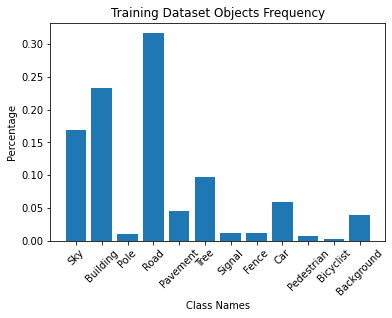

No of training images: 294
No of validation images: 73


In [5]:
NUMCLASSES = 12
IMAGESIZE = 256
backBone = 'DenseNet121'  # 'VGG16'
classNameList = ['Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'Signal', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Background']
# shutil.unpack_archive('A3_Dataset.zip')
trainImageDir = os.path.join('A3_Dataset','dataset1','images_prepped_train')
trainMaskDir = os.path.join('A3_Dataset','dataset1','annotations_prepped_train')
trainingImageNameList = sorted(glob(os.path.join('A3_Dataset','dataset1','images_prepped_train/*')))
trainingMaskNameList = sorted(glob(os.path.join('A3_Dataset','dataset1','annotations_prepped_train/*')))
# Calculate class weights and plot histogram
groundTruthMaskList = ReadGroundTruthMasks(trainingMaskNameList)
pixelCount = CalculateNumberOfPixelForClass(groundTruthMaskList)
classWeights = CalculateClassWeight(pixelCount, 0.999999)
PlotClassHistogram(classNameList, (pixelCount/sum(pixelCount)), 'Training Dataset Objects Frequency')
# Split training dataset and form datagenerator for passing to the training model
trainImageNameList, trainMaskNameList, valImageNameList, valMaskNameList = DatasetSplit(imageNameList=trainingImageNameList, maskNameList=trainingMaskNameList, valPercentage=20)
trainDatasetGenerator = CustomDataGenerator(trainImageNameList, trainMaskNameList, batchSize=32, augmentationFlag = True)
trainDataset = trainDatasetGenerator.DataGenerator()
valDatasetGenerator = CustomDataGenerator(valImageNameList, valMaskNameList, batchSize=16, augmentationFlag = False)
valDataset = valDatasetGenerator.DataGenerator()
print("No of training images:", str(len(trainImageNameList)))
print("No of validation images:", str(len(valImageNameList)))

## Support Function for Decoder Module

In [6]:
# This function adds a Convolution layer followed by Batchnorm and ReLU activation
def ConvBlock(inputLayer, noFilters, kernelSize, dilationRate, layerName, use_bias=False):
    layerName = layerName +'_Conv'
    x = Conv2D(noFilters, kernel_size=kernelSize, dilation_rate=dilationRate,  padding="same", 
               use_bias=False, kernel_initializer=tf.keras.initializers.HeNormal(), name = layerName)(inputLayer)
    layerName = layerName + '_BatchNorm'
    x = BatchNormalization(name = layerName)(x)
    layerName = layerName + '_ReLU'
    x = ReLU(name = layerName)(x)
    return x
# This function adds cascaded convolution layers after the bottleneck layer
def CenterConvBlock(x):
    for i in range(1,3):
        layerName = 'CenterConvBlock'+'_'+str(i)+'_3x3'
        x = Conv2D(512,kernel_size=(3,3), strides=(1,1),padding='same', name = layerName)(x)
        layerName = 'CenterConvBlock' + '_'+str(i) + '_BatchNorm'
        x = BatchNormalization(name = layerName)(x)
        layerName = 'CenterConvBlock' + '_'+str(i) + '_ReLU'
        x = ReLU(name = layerName)(x)
    return x
# This function implements a Atrous Spatial Pyramid Pooling Block used for handling multiscale objects
def AtrousSpatialPyramidPoolingBlock(inputLayer, noFilters):
    dims = inputLayer.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(inputLayer)
    x = ConvBlock(inputLayer=x, noFilters=noFilters, kernelSize=1, dilationRate=1, layerName='ASPP_ImagePool', use_bias=True)
    out_pool = UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear")(x)
    
    out_1 = ConvBlock(inputLayer=inputLayer, noFilters=noFilters, kernelSize=1, dilationRate=1, layerName='ASPP_Dilation_1')
    out_6 = ConvBlock(inputLayer=inputLayer, noFilters=noFilters, kernelSize=3, dilationRate=6, layerName='ASPP_Dilation_6')
    out_12 = ConvBlock(inputLayer=inputLayer, noFilters=noFilters, kernelSize=3, dilationRate=12, layerName='ASPP_Dilation_12')
    out_18 = ConvBlock(inputLayer=inputLayer, noFilters=noFilters, kernelSize=3, dilationRate=18, layerName='ASPP_Dilation_18')

    x = Concatenate(axis=-1, name='ASPP_Concatenate')([out_pool, out_1, out_6, out_12, out_18])
    output = ConvBlock(inputLayer=x, noFilters=noFilters*2, kernelSize=1, dilationRate=1, layerName='ASPP_Out')
    return output
# This function is used for Upsampling the feature maps using the concatenated feature maps from corresponding encoder layer
# and applying 02 Convs along with Batchnorm and ReLU activation
def DecoderBlock(noOfFilters, inputLayer, convBlockName, model, concatLayerName, concatFlag=True):
    layerName = convBlockName+'_'+'TransposeConv'+'_3x3'
    x = Conv2DTranspose(noOfFilters,kernel_size=(3,3), strides=(2,2),padding='same', name = layerName, activation='relu')(inputLayer)
    if concatFlag:
        layerName = convBlockName+'_'+'Concat'
        x = Concatenate(name = layerName)([x,model.get_layer(concatLayerName).output])
    for i in range(1,3):
        layerName = convBlockName+'_'+str(i)
        x = ConvBlock(inputLayer=x, noFilters=noOfFilters//2, kernelSize=3, dilationRate=1, layerName=layerName)
    return x
# This function adds a decoder module to the pre-built model
# In this case model is Densenet 121 pre-trained on imagenet dataset
def AddDecoderModuleDenseNet(model):
    # x = model.layers[-1].output
    x = model.get_layer('pool4_conv').output
    x = AtrousSpatialPyramidPoolingBlock(inputLayer=x, noFilters=512)
    # x = DecoderBlock(noOfFilters = 512, inputLayer=x, convBlockName='DecoderBlock_1', model=model, concatLayerName='pool4_conv')
    x = DecoderBlock(noOfFilters = 256, inputLayer=x, convBlockName='DecoderBlock_2', model=model, concatLayerName='pool3_conv')
    x = DecoderBlock(noOfFilters = 128, inputLayer=x, convBlockName='DecoderBlock_3', model=model, concatLayerName='pool2_conv')
    x = DecoderBlock(noOfFilters = 64, inputLayer=x, convBlockName='DecoderBlock_4', model=model, concatLayerName='conv1/relu')
    x = DecoderBlock(noOfFilters = 32, inputLayer=x, convBlockName='DecoderBlock_5', model=None, concatLayerName=None, concatFlag=False)
    layerName = 'Final_Conv_Layer'
    x = Conv2D(12,kernel_size=(3,3), strides=(1,1),padding='same', name = layerName)(x)
    layerName = 'Final_Softmax_Layer'
    x = Softmax(name = layerName)(x)
    model = Model(inputs=model.layers[0].input, outputs=x)
    return model
# This function adds a decoder module to the pre-built model
# In this case model is VGG16 pre-trained on imagenet dataset
def AddDecoderModuleVGG16(model):
    x = model.layers[-1].output
    x = CenterConvBlock(x)
    x = DecoderBlock(noOfFilters = 512, inputLayer=x, convBlockName='DecoderBlock_1', model=model, concatLayerName='block5_conv3')
    x = DecoderBlock(noOfFilters = 256, inputLayer=x, convBlockName='DecoderBlock_2', model=model, concatLayerName='block4_conv3')
    x = DecoderBlock(noOfFilters = 128, inputLayer=x, convBlockName='DecoderBlock_3', model=model, concatLayerName='block3_conv3')
    x = DecoderBlock(noOfFilters = 64, inputLayer=x, convBlockName='DecoderBlock_4', model=model, concatLayerName='block2_conv2')
    x = DecoderBlock(noOfFilters = 32, inputLayer=x, convBlockName='DecoderBlock_5', model=None, concatLayerName=None, concatFlag=False)
    layerName = 'Final_Conv_Layer'
    x = Conv2D(12,kernel_size=(3,3), strides=(1,1),padding='same', name = layerName)(x)
    layerName = 'Final_Softmax_Layer'
    x = Softmax(name = layerName)(x)

    model = Model(inputs=model.layers[0].input, outputs=x)
    return model

## Model Assemble <br>
Combine encoder and decoder modules

In [11]:
if backbone == 'DenseNet121':
    model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMAGESIZE,IMAGESIZE,3))
    model = AddDecoderModule(model)
else:
    model = VGG16(include_top=False, weights='imagenet', input_shape=(IMAGESIZE,IMAGESIZE,3))
    model = AddDecoderModule(model)
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

29097984/29084464 [==============================] - 0s 0us/step


## Model Compilation <br>
Compiles the model with Adam optimizer. <br>
The model saves the best trained model based of validation Dice Coefficient. <br>
Train the model for desired number of epochs.

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,amsgrad=True),
                   loss=CustomLossFunction, metrics=["accuracy",DiceCoefficient])

historyLoggerPath = os.path.join('drive','MyDrive','historyLog-Densenet.csv')
historyLogger = CSVLogger(historyLoggerPath, separator=",", append=True)
learningRateAdjustment = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=0.00001, verbose=1)
checkpointPath = 'BestModel.epoch{epoch:02d}-DiceCoefficient{val_DiceCoefficient:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpointPath, monitor='val_DiceCoefficient', mode='max', save_best_only=True)

callbacks = [historyLogger, learningRateAdjustment, checkpoint]
history = model.fit(trainDataset, verbose=1, epochs=140, callbacks = callbacks,
                         validation_data=valDataset)

Epoch 1/40
10/10 [==============================] - 28s 2s/step - loss: 0.1871 - accuracy: 0.8956 - DiceCoefficient: 0.8548 - val_loss: 0.3665 - val_accuracy: 0.8621 - val_DiceCoefficient: 0.8204 - lr: 1.0000e-04
Epoch 2/40
10/10 [==============================] - 13s 1s/step - loss: 0.1794 - accuracy: 0.8980 - DiceCoefficient: 0.8572 - val_loss: 0.3675 - val_accuracy: 0.8600 - val_DiceCoefficient: 0.8138 - lr: 1.0000e-04
Epoch 3/40
10/10 [==============================] - 13s 1s/step - loss: 0.1819 - accuracy: 0.8993 - DiceCoefficient: 0.8565 - val_loss: 0.3731 - val_accuracy: 0.8606 - val_DiceCoefficient: 0.8132 - lr: 1.0000e-04
Epoch 4/40
10/10 [==============================] - 13s 1s/step - loss: 0.1923 - accuracy: 0.8941 - DiceCoefficient: 0.8573 - val_loss: 0.3729 - val_accuracy: 0.8616 - val_DiceCoefficient: 0.8194 - lr: 1.0000e-04
Epoch 5/40
10/10 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.8977 - DiceCoefficient: 0.8592
Epoch 5: ReduceLROnPlateau r

## Support Functions for model evaluation

In [31]:
# This function is used for plotting the training graphs of the model
def PlotTrainingGraph(history, graphType):
    trainingValue = history.history[graphType]
    validationValue = history.history['val_'+graphType]
    plot_epochs = range(1, len(trainingValue)+1)

    plt.plot(plot_epochs, trainingValue, 'r', label='Training')
    plt.plot(plot_epochs, validationValue, 'b', label='Validation')
    plt.title(graphType+' '+'graph')
    plt.ylabel(graphType)  #Y-axis label
    plt.xlabel('epoch')  #X-axis label
    plt.legend()
    plt.show()
# This function is used for calculating the evaluation metrics (sensitivity, specificity and precision)    
def CalculateNetEvalMetrics(groundTruthMaskArray,predictedMaskArray, noClasses):
    cumSensitivity = np.zeros(noClasses)
    cumSpecificity = np.zeros(noClasses)
    cumPrecision = np.zeros(noClasses)
    cumzeroFlagSensitivity = np.zeros(noClasses)
    cumzeroFlagSpecificity = np.zeros(noClasses)
    cumzeroFlagPrecision = np.zeros(noClasses)
    for i in tqdm(range(len(groundTruthMaskArray))):
        groundTruthMask = groundTruthMaskArray[i,:,:]
        predictedMask = predictedMaskArray[i,:,:]
        zeroFlagSensitivity, sensitivity, zeroFlagSpecificity, specificity, zeroFlagPrecision, precision = CalculateEvalMetricsSingleMask(groundTruthMask, predictedMask, noClasses)
        cumSensitivity += sensitivity
        cumzeroFlagSensitivity += zeroFlagSensitivity
        cumSpecificity += specificity
        cumzeroFlagSpecificity += zeroFlagSpecificity
        cumPrecision += precision
        cumzeroFlagPrecision += zeroFlagPrecision
    meanSensitivity = cumSensitivity/(len(groundTruthMaskArray) - cumzeroFlagSensitivity + 0.000001)
    meanSpecificity = cumSpecificity/(len(groundTruthMaskArray) - cumzeroFlagSpecificity + 0.000001)
    meanPrecision = cumPrecision/(len(groundTruthMaskArray) - cumzeroFlagPrecision + 0.000001)
    meanF1Score = 2*meanPrecision*meanSensitivity/(meanPrecision+meanSensitivity)
    return meanSensitivity, meanSpecificity, meanF1Score    
## Calculate metrics for single image and mask
def CalculateEvalMetricsSingleMask(groundTruthMask, predictedMask, noClasses):
    tp = np.zeros(noClasses)
    fn = np.zeros(noClasses)
    pp = np.zeros(noClasses)
    pn = np.zeros(noClasses)
    sensitivity = np.zeros(noClasses)
    specificity = np.zeros(noClasses)
    precision = np.zeros(noClasses)
    for i in range(groundTruthMask.shape[0]):
        for j in range(groundTruthMask.shape[1]):
            if groundTruthMask[i][j] == predictedMask[i][j]:
                tp[groundTruthMask[i][j]] = tp[groundTruthMask[i][j]] + 1
            else:
                fn[groundTruthMask[i][j]] = fn[groundTruthMask[i][j]] + 1

    for i in range(noClasses):
        pp[i] = np.count_nonzero(predictedMask == i)
        pn[i] = groundTruthMask.shape[0]*groundTruthMask.shape[1] - pp[i]
    fp = pp - tp
    tn = pn - fn

    zeroFlagSensitivity, sensitivity = CalculateMetric(tp,fn, noClasses)
    zeroFlagSpecificity, specificity = CalculateMetric(tn,fp, noClasses)
    zeroFlagPrecision, precision = CalculateMetric(tp,fp, noClasses)
    return zeroFlagSensitivity, sensitivity, zeroFlagSpecificity, specificity, zeroFlagPrecision, precision
# This function calculates the individual metric 
def CalculateMetric(a,b, noClasses):
    metricArray = np.zeros(noClasses)
    zeroFlag = np.zeros(noClasses)
    for i in range(noClasses):
        noOfZeros = 0
        if (a[i] + b[i]) == 0:
            metricArray[i] = 0
            zeroFlag[i] = 1
        else:
            metricArray[i] = a[i]/(a[i]+b[i])
    return zeroFlag, metricArray
# This function reads the ground truth masks
def ReadGroundTruthMasks(testMaskNameList):
    groundTruthMaskList = []
    for i in testMaskNameList:
        mask = tf.io.read_file(i)
        mask = tf.image.decode_png(mask, channels=1)
        mask.set_shape([None, None, 1])
        mask = tf.image.resize(images=mask, size=[256, 256])
        mask = K.cast(mask, dtype='int32')
        mask = K.squeeze(mask, axis=-1)
        groundTruthMaskList.append(mask)
    groundTruthMaskArray = np.array(groundTruthMaskList)
    return groundTruthMaskArray
# This function reads images
def ReadImages(testImageNameList):
    testImagesList = []
    for i in testImageNameList:
        image = io.imread(i)
        image = resize(image, (256, 256))
        testImagesList.append(image)
    return testImagesList
# This function gives the arg max for predicted masks
def ProcessPredictedMasks(predictions):
    predictedMaskArray = np.argmax(predictions, axis=-1)
    return predictedMaskArray
# This function displays the images with its mask
def DisplayImageMask(image,mask, maskType):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Image')
    #plot the mask
    im = axs[1].imshow(mask)
    values = np.unique(mask.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label=classNameList[i] ) for i in range(len(values))]
    axs[1].axis('off') 
    axs[1].set_title(maskType)
    axs[1].legend(handles=patches, bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=0.0)
    #plot image and add the mask
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha = 0.5)
    axs[2].axis('off')   
    axs[2].set_title('Image with ' + maskType)
    # set suptitle
    # plt.suptitle('Image with mask overlay')
    plt.show()

## Plot Training Graphs

In [30]:
PlotTrainingGraph(history, 'loss')
PlotTrainingGraph(history, 'accuracy')
PlotTrainingGraph(history, 'DiceCoefficient')

## Read Test Dataset

In [28]:
testImageNameList = sorted(glob(os.path.join('A3_Dataset','dataset1','images_prepped_test/*')))
testMaskNameList = sorted(glob(os.path.join('A3_Dataset','dataset1','annotations_prepped_test/*')))
print('Number of images: ' + str(len(testImageNameList)))
print('Number of masks: ' + str(len(testMaskNameList)))

Number of images: 101
Number of masks: 101


## Predict on Test Dataset

In [32]:
groundTruthMaskArray = ReadGroundTruthMasks(testMaskNameList)
testImagesList = ReadImages(testImageNameList)
testDatasetGenerator = CustomDataGenerator(testImageNameList, testMaskNameList, batchSize=32, augmentationFlag = False)
testDataset = testDatasetGenerator.DataGenerator()
score = model.evaluate(testDataset)
predictions = model.predict(testDataset,verbose=1)
predictedMaskArray = ProcessPredictedMasks(predictions)
sensitivity, specificity, meanF1Score = CalculateNetEvalMetrics(groundTruthMaskArray,predictedMaskArray, NUMCLASSES)
print('sensitivity' + str(sensitivity))
print('specificity' + str(specificity))
print('meanF1Score' + str(meanF1Score))

4/4 [==============================] - 18s 4s/step


100%|██████████| 101/101 [00:22<00:00,  4.44it/s]

sensitivity[0.97052529 0.85369165 0.0620956  0.95834503 0.92518643 0.96064697
 0.20419368 0.70959547 0.6381168  0.61681392 0.76675734 0.06547715]
specificity[0.99607376 0.98573465 0.99159906 0.99549125 0.98529797 0.97971533
 0.99793749 0.98017226 0.99657861 0.98575475 0.99047459 0.99721962]
meanF1Score[0.96586728 0.9005049  0.05287095 0.97323765 0.88753714 0.93160934
 0.27562076 0.61309438 0.66642569 0.37013637 0.69680694 0.10300322]


## Display Visual Results for Comparison

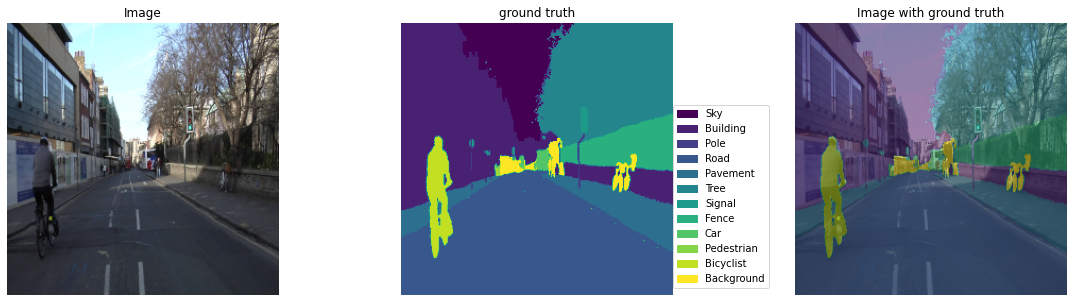

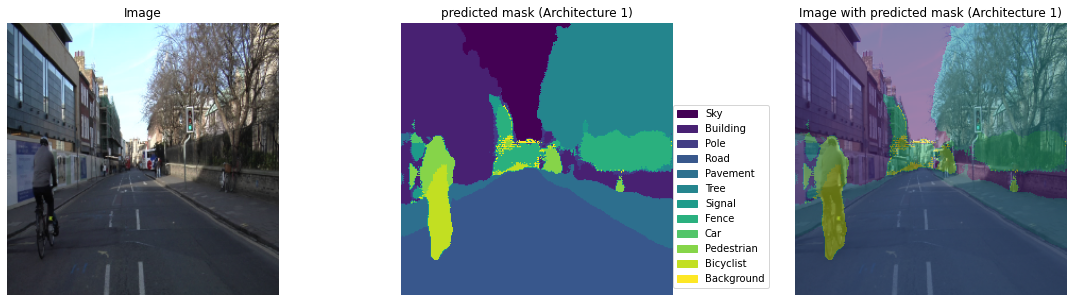

In [35]:
imageNumber = 100
DisplayImageMask(testImagesList[imageNumber],groundTruthMaskArray[imageNumber,:,:], 'ground truth')
DisplayImageMask(testImagesList[imageNumber],predictedMaskArray[imageNumber,:,:], 'predicted mask (Architecture 1)')